In [678]:
###################################################################################################
##################### CODE TO CLEAN CSV FILES FROM KESTREL DROP D2 SENSORS ########################
###################################################################################################
# Read in the packages to use
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import shutil # for copying 

## Run the code and check the data highlighted to ensure the errors are fixed or will not be an issue for the data analysis

## Manual Inputs: 
## Specify the folder where the csvs are located
## Specify the filename for the datasets containing all of the sensor data
## Specify the dates for which the data is valid between (i.e. remove set up day where the data won't be valid etc,..)
## Specify the data collection frequency

from pathlib import Path

sensor_csv_folder = Path.home() / "Documents" / "eh scholars" / "raw data" / "week 4"
name_for_data='Week4' #string which will be at the beginning of the saved clean csvs (2 created) with all data
collection_interval = 20 # (in minutes)
# start and end dates - 30 mins before (start) or 30 minutes after (end) to account for hour averaging
start_datetime = datetime.strptime('2025-07-06 23:30:00', '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.strptime('2025-07-12 23:30:00', '%Y-%m-%d %H:%M:%S')

######## IMPORTANT !!!!!!!!! #######

# If the code has made corrections, manually check the files that are flagged in the correction 1 and 2 to make sure the correction is appropriate

####################################
######### CORRECTION 1 #############
####################################

## check for files with timestamps that need correcting

## The timestamps need correcting because the battery was removed and replaced upon install. For some sensors, the time did not sync
## when set up, and was set as the time when the battery was removed. for where this is the case, a reading with the correct time stamp 
## was taken, which is used to recalibrate the readings to the correct time stamps. 
## loop through the filelist and return the filenames where there is over 10 minutes between the last and second to last data points (only these points)

####################################
######### CORRECTION 2 #############
####################################

## Check for files where the logging rate was set to 1 minute
## these files need to be updated to readings every 10 mins (so readings not at XX:X0 removed)
## this is based on a past issue, so this might need to be changed to the new calbration interval now

#####################################
######### SENSE CHECK 1 #############
#####################################

## Check to see if there is any files where the gaps between data are greater than 10 mins, but these do not include the 
## files which fall into the correction 1 category
## there is a known error where the files stop recording at 1hr 20. Note these files and when it is happening

#####################################
######### SENSE CHECK 2 #############
#####################################

## Check to see if there is any files where the gaps between data are less than the collection interval

In [679]:
# folder to save the clean csvs into. If it doesn't exist, create it 
folder_for_clean_csvs = os.path.join(sensor_csv_folder,"Data_Clean")
if not os.path.exists(folder_for_clean_csvs):
        os.makedirs(folder_for_clean_csvs)

# function to read the csv file and return and pd df of the data with a column containing datetime format
def generate_df(filename):
    sensor_id = filename[5:12]
    filename_filepath = os.path.join(sensor_csv_folder, filename)
    sensor_data = pd.read_csv(filename_filepath, skiprows=[0, 1,2]).rename(columns = {'FORMATTED DATE_TIME':'Date_Time',
                                    'Relative Humidity':'Relative_Humidity','Heat Index':'Heat_Index','Dew Point':'Dew_Point'}
                                   )[['Date_Time','Temperature', 'Relative_Humidity','Heat_Index','Dew_Point']]
    #getting rid of the 1st row which is formatting info not data
    sensor_data = sensor_data[1:].reset_index(drop = True)
    #get the datetime formatted properly

    # there are a few different date time formats in the csvs, so first try the most common one 
    try:
        sensor_data['Date_Time_Format'] = sensor_data.apply(lambda row: datetime.strptime(row.Date_Time, '%Y-%m-%d %I:%M:%S %p'), axis=1)
    # if this isn't the format the data is in, there are two others it could be in 
    except ValueError:
    # for if the format is month/ day
        try:
            sensor_data['Date_Time_Format'] = sensor_data.apply(lambda row: datetime.strptime(row.Date_Time, '%m/%d/%Y %H:%M'), axis=1)   
        except ValueError:
        # if the format is day/ month
            try:
                sensor_data['Date_Time_Format'] = sensor_data.apply(lambda row: datetime.strptime(row.Date_Time, '%d/%m/%Y %H:%M:%S'), axis=1)
            except ValueError:
                try:
                    sensor_data['Date_Time_Format'] = sensor_data.apply(lambda row: datetime.strptime(row.Date_Time, '%Y-%m-%d %H:%M:%S'), axis=1)
                except ValueError:	             
                    print('cant find date format type')
    return sensor_data

# function to save the data in with the new date time format as a csv, which can be read in directly to pandas df
def data_save(filename):
    sensor_data = generate_df(filename)
    sensor_data = sensor_data.drop('Date_Time', axis=1)  # get rid of the old date/ time which is in mixed formats
    sensor_data.to_csv(r'{}/{}'.format(folder_for_clean_csvs,filename), index=False) 

###### Get the filenames #######
#list the sensor files to clean
file_name_list = []
sensor_id_list = []
for file_name in os.listdir(sensor_csv_folder):
    if file_name.endswith(".csv"):
        file_name_list.append(file_name)
        sensor_id_list.append(file_name[5:12])

# get dataframe with the number of files for each sensor 
files_df = pd.DataFrame({'sensor_id':sensor_id_list, 'filename': file_name_list})
filecounts = files_df.groupby('sensor_id').count().reset_index()

# flag it up if there is a sensor which has more than one csv file
if len(filecounts[filecounts.filename > 1]) > 0:
    print('Multiple files for the same sensor')

# create lists for the filenames which need correcting/ checking to be saved into 
correction_1_filenames = []
correction_2_filenames = []
sense_check_1_filenames = []
sense_check_1_rows = []
sense_check_1_1hr20m = []
sense_check_1_time = []
sense_check_2_filenames = []
sense_check_2_rows = []
sense_check_2_time = []
error_in_timeframe = 0

# loop through files, carry out checks
for i in range(len(file_name_list)):
    sensor_data = generate_df(file_name_list[i])
    sensor_id = file_name_list[i][5:12]
    
    # check that the collection interval is correct, and flag it up if not
    if sensor_data.Date_Time_Format.iloc[5] - sensor_data.Date_Time_Format.iloc[4] != timedelta(minutes = collection_interval):
        interval  = round((sensor_data.Date_Time_Format.iloc[5] - sensor_data.Date_Time_Format.iloc[4]).total_seconds()/60)
        print('Interval is set to {} minutes: {}'.format(interval, file_name_list[i]))
    
    # check for correction 1 needed
    if (sensor_data.Date_Time_Format.iloc[-1] - sensor_data.Date_Time_Format.iloc[-2] > timedelta(minutes = collection_interval))&(
        sensor_data.Date_Time_Format.iloc[5] - sensor_data.Date_Time_Format.iloc[4] == timedelta(minutes = collection_interval)):
        # get the filename which needs correction
        correction_1_filenames.append(file_name_list[i])
        correction_1 = True
    else: 
        correction_1 = False
    
    # filter the data for the timeperiod which the data will be used for
    # the filtering is carried out after the correction 1 is applied (as it would remove required data) 
    sensor_data2 = sensor_data[(sensor_data['Date_Time_Format'] > start_datetime)&(
                    sensor_data['Date_Time_Format'] < end_datetime)].reset_index(drop = True) 
    
    
    if len(sensor_data2) == 0:
        print('Error: Inspect file',file_name_list[i],'has no values for the requested timeframe')
        error_in_timeframe = 1
        break
    
            # check for correction 2 needed
    if sensor_data2.Date_Time_Format[1] - sensor_data2.Date_Time_Format[0] == timedelta(minutes = 1):
        # get the filename which needs correction
        correction_2_filenames.append(file_name_list[i])
        correction_2 = True
    else: correction_2 = False
    
    # complete the sense checks
    for row_num in range(len(sensor_data2) - 1):
        # sense check 1 (gaps greater than the collection interval)
        if sensor_data2.Date_Time_Format[row_num+1] - sensor_data2.Date_Time_Format[row_num] > timedelta(minutes = collection_interval):
            # checking for gap being 1hr 20m
            if sensor_data2.Date_Time_Format[row_num+1] - sensor_data2.Date_Time_Format[row_num] == timedelta(hours=1, minutes=20):
                sense_check_1_1hr20m.append(1)
            else:
                sense_check_1_1hr20m.append(0)
                further_investigation = True
            # saving filename and row num of gap
            sense_check_1_filenames.append(file_name_list[i])
            sense_check_1_time.append(sensor_data2.Date_Time_Format[row_num+1])
            # get the old row num (before the index was reset from the duplicate data removal
            prev_row_num = sensor_data[sensor_data.Date_Time_Format == sensor_data2.Date_Time_Format[row_num+1]].index.values[0]
            sense_check_1_rows.append(prev_row_num)
            
        #sense check 2 (observation frequencies higher than collection interval)
        if sensor_data2.Date_Time_Format[row_num+1] - sensor_data2.Date_Time_Format[row_num] < timedelta(minutes = collection_interval):
            # flag the file for further investigation
            further_investigation = True
            # saving filename and row num of gap
            sense_check_2_filenames.append(file_name_list[i])
            sense_check_2_time.append(sensor_data2.Date_Time_Format[row_num+1])
            # get the old row num (before the index was reset from the duplicate data removal
            prev_row_num = sensor_data[sensor_data.Date_Time_Format == sensor_data2.Date_Time_Format[row_num+1]].index.values[0]
            sense_check_2_rows.append(prev_row_num)

    # save the csvs which are already clean to a new folder, MAKE SURE TO MANUAL INVESTIGATE ANY FLAGGED *** 
    sensor_data2 = sensor_data2.drop('Date_Time', axis=1)  # get rid of the old date/ time which is in mixed formats
    sensor_data2.to_csv(r'{}/{}'.format(folder_for_clean_csvs,file_name_list[i]), index=False)  

sense_check_1_df = pd.DataFrame({'Filename':sense_check_1_filenames, 'Row_Number': sense_check_1_rows,'Difference_is_1hr20m':sense_check_1_1hr20m,
                                'Date_Time': sense_check_1_time})

sense_check_2_df = pd.DataFrame({'Filename':sense_check_2_filenames, 'Row_Number': sense_check_2_rows, 'Date_Time': sense_check_2_time})


# print how many files fall into each category
print('{} files need correction 1'.format(len(correction_1_filenames)))
print('{} files need correction 2'.format(len(correction_2_filenames)))
print('{} files flagged by sense check 1'.format(len(set(sense_check_1_df.Filename))))
print('{} files flagged by sense check 2'.format(len(set(sense_check_2_df.Filename))))

########## CARRY OUT CORRECTION 1 ###########
for i in range(len(correction_1_filenames)):
    sensor_data = generate_df(correction_1_filenames[i])

    ## get the time difference between the final 2 rows, minus 10 minutes 
    ## (this will be how much to add onto the rest of the data to correct it) 
    correction_time_diff = (sensor_data.Date_Time_Format.iloc[-1] - sensor_data.Date_Time_Format.iloc[-2]) - timedelta(minutes = collection_interval) 
    ## add on the correction 
    sensor_data['Date_Time_Format2'] = sensor_data.Date_Time_Format + correction_time_diff
    ## but the final row will still be the original so keep that 
    time_stamp_to_correct = sensor_data['Date_Time_Format2'].iloc[-1]
    sensor_data.loc[sensor_data.Date_Time_Format2 == time_stamp_to_correct, 'Date_Time_Format2' ] = sensor_data['Date_Time_Format'].iloc[-1]
    ## some housekeeping, getting rid of the 2 incorrect date cols, rename the new one
    sensor_data = sensor_data.drop(['Date_Time','Date_Time_Format'], axis=1).rename(columns = {'Date_Time_Format2':'Date_Time_Format'})
    ## filter the data 
    sensor_data2 = sensor_data[(sensor_data['Date_Time_Format'] > start_datetime)&(
                    sensor_data['Date_Time_Format'] < end_datetime)].reset_index(drop =True) 
    ## save the final df as a csv
    sensor_data2.to_csv(r'{}/{}'.format(folder_for_clean_csvs,correction_1_filenames[i]), index=False) 

print('Correction 1 complete (if required)')

########## CARRY OUT CORRECTION 2 ###########
## 8 files which need correction 2
for i in range(len(correction_2_filenames)):
    sensor_data = generate_df(correction_2_filenames[i])
    ## filter the df so that only the data at 10 minute intervals remains and get rid of the old date time column in the inconsistent format
    filtered_sensor_data = sensor_data[sensor_data['Date_Time_Format'].dt.minute % 10 == 0].drop('Date_Time', axis=1)
    ## save the final df as a csv
    filtered_sensor_data.to_csv(r'{}/{}'.format(folder_for_clean_csvs,correction_2_filenames[i]), index=False) 

print('Correction 2 complete (if required)')

######################################################
#### CREATE A CSV OF ALL THE DATA MERGED INTO ONE ####
######################################################

# empty df to be filled
sensor_data_all = pd.DataFrame()

for filename in file_name_list:   
    filename_filepath = os.path.join(folder_for_clean_csvs, filename)
    sensor_data = pd.read_csv(filename_filepath)
    sensor_data['Sensor_ID']= files_df[files_df.filename == filename].sensor_id.values[0]
    sensor_data_all = pd.concat([sensor_data_all,sensor_data])


#reset the index (makes further analysis in this code easier, but not necessary if just saving the csv
sensor_data_all = sensor_data_all.reset_index(drop = True)#.drop(columns = 'Date_Time')
sensor_data_all['Date_Time_Format'] = sensor_data_all.apply(lambda row: datetime.strptime(row.Date_Time_Format, '%Y-%m-%d %H:%M:%S'), axis=1)


# Save the new data
sensor_data_all.to_csv(r'{}/{}_cleaned.csv'.format(folder_for_clean_csvs,name_for_data), index=False)

#######################################################################
#### Create a 'no gaps' dataset, which fills in the gaps with NaNs ####
#######################################################################

## this is just to make it easier for analysis and so it is clear where the gaps are
# create a df to fill with the new 'no gaps' data
sensor_data_all_no_gaps = pd.DataFrame()

#get a list of all the sensor ids
sensor_id_list = list(set(sensor_data_all.Sensor_ID))

for sensor_id in sensor_id_list:
    # df for the selected sensor
    sensor_data_ind = sensor_data_all[sensor_data_all.Sensor_ID == sensor_id].sort_values(by = 'Date_Time_Format',ascending=True
                                                                                         ).reset_index(drop = True)
    
    for row_num in range(len(sensor_data_ind) - 1):
        # find where there are gaps in the timeseries
        if sensor_data_ind.Date_Time_Format[row_num+1] - sensor_data_ind.Date_Time_Format[row_num] > timedelta(minutes = collection_interval):
            start_time = sensor_data_ind.Date_Time_Format[row_num]
            end_time = sensor_data_ind.Date_Time_Format[row_num+1]

            missed_date_times = pd.date_range(start=start_time + timedelta(minutes = collection_interval), 
                                              end=end_time - timedelta(minutes = collection_interval), 
                                              freq='{}min'.format(collection_interval)).to_list()

            # df to concat containing the missed time intervals and sensor ID. Nans for the measurement values/ collection number. 
            nans_df = pd.DataFrame()
            nans_df['Date_Time_Format'] = missed_date_times
            nans_df['Sensor_ID'] = sensor_id

            sensor_data_ind = pd.concat([sensor_data_ind, nans_df]).sort_values(by = 'Date_Time_Format').reset_index(drop = True)

    # add the sensor data into the overall dataframe
    sensor_data_all_no_gaps = pd.concat([sensor_data_all_no_gaps, sensor_data_ind])


#reset the index (makes further analysis in this code easier, but not necessary if just saving the csv
sensor_data_all_no_gaps = sensor_data_all_no_gaps.reset_index(drop = True)
# Save the new data, comment out if there's an offset
sensor_data_all_no_gaps.to_csv(r'{}/{}_cleaned_const_timeseries.csv'.format(folder_for_clean_csvs,name_for_data), index=False)

if error_in_timeframe == 1:
    print('Incomplete Cleaning, check error in timeframe')
else:    
    print('Cleaning Complete')

0 files need correction 1
0 files need correction 2
0 files flagged by sense check 1
0 files flagged by sense check 2
Correction 1 complete (if required)
Correction 2 complete (if required)
Cleaning Complete


In [680]:
# account for offset if needed 
#sensor_data_all_no_gaps.loc[sensor_data_all_no_gaps.Sensor_ID == '2974345', 'Date_Time_Format'] = sensor_data_all_no_gaps.loc[sensor_data_all_no_gaps.Sensor_ID == 2974345, 'Date_Time_Format'] + timedelta(days=1, hours=7, minutes=20)
#sensor_data_all_no_gaps.to_csv(r'{}/{}_cleaned_const_timeseries.csv'.format(folder_for_clean_csvs,name_for_data), index=False)

Text(0, 0.5, 'Temperature (°F)')

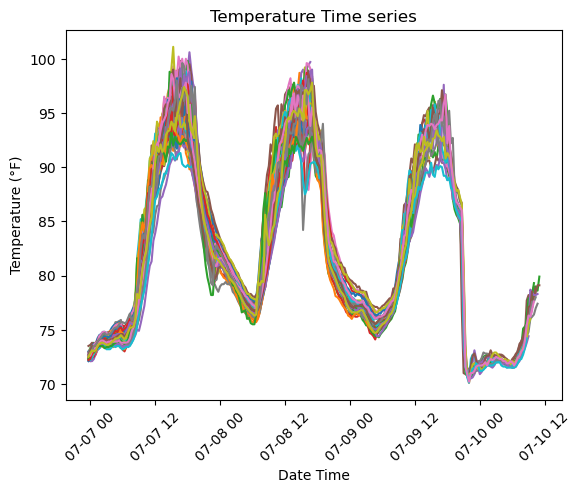

In [681]:
############## Create time series plots to flag up if there are any issues in the data ######################
data_to_plot = sensor_data_all_no_gaps[~sensor_data_all_no_gaps.Sensor_ID.isin(remove_ids)].reset_index(drop = True)

for sensor_id in sensor_id_list:
    sensor_data = data_to_plot[data_to_plot.Sensor_ID == sensor_id]
    plt.plot(sensor_data.Date_Time_Format, sensor_data.Temperature, #pd.to_numeric(all_sensors_filter[sensor_name_temp]),
           label = sensor_id)

# plt.legend(title = 'Sensor_ID')
plt.xticks(rotation=45)
plt.title('Temperature Time series')
plt.xlabel( 'Date Time')
plt.ylabel ('Temperature (\u00B0F)')

#plt.savefig(os.path.join(folder_for_clean_csvs,'calibration_timeseries.png'))

Text(0, 0.5, 'Heat Index')

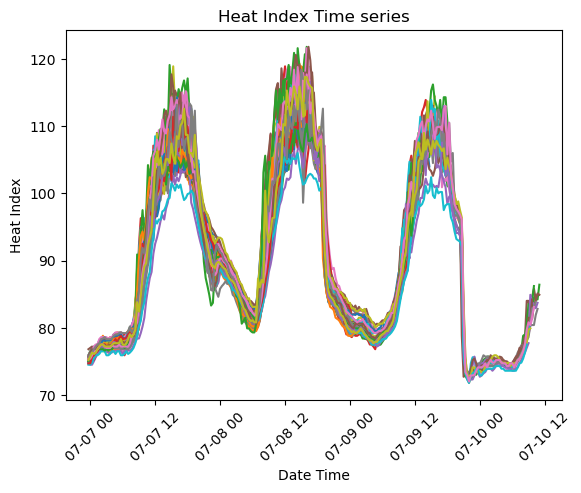

In [682]:
############## Create time series plots to flag up if there are any issues in the data ######################
data_to_plot = sensor_data_all_no_gaps[~sensor_data_all_no_gaps.Sensor_ID.isin(remove_ids)].reset_index(drop = True)

for sensor_id in sensor_id_list:
    sensor_data = data_to_plot[data_to_plot.Sensor_ID == sensor_id]
    plt.plot(sensor_data.Date_Time_Format, sensor_data.Heat_Index, #pd.to_numeric(all_sensors_filter[sensor_name_temp]),
           label = sensor_id)

#plt.legend(title = 'Sensor_ID')
plt.xticks(rotation=45)
plt.title('Heat Index Time series')
plt.xlabel( 'Date Time')
plt.ylabel ('Heat Index')

# plt.savefig(os.path.join(folder_for_clean_csvs,'heat_index_calibration_timeseries.png'))

Text(0, 0.5, 'Temperature (°F)')

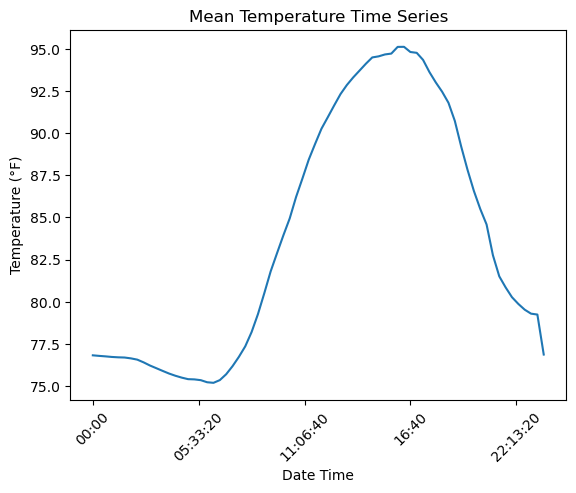

In [683]:
# Daily time series plot across entire week

data_to_plot_time = data_to_plot
data_to_plot_time['time_only'] = data_to_plot['Date_Time_Format'].dt.time
data_to_plot_time_only = data_to_plot_time.groupby('time_only')['Temperature'].mean()

data_to_plot_time_only.plot()

#plt.legend(title = 'Sensor_ID')
plt.xticks(rotation=45)
plt.title('Mean Temperature Time Series')
plt.xlabel('Date Time')
plt.ylabel ('Temperature (\u00B0F)')

#plt.savefig(os.path.join(folder_for_clean_csvs,'mean_calibration_timeseries.png'))

In [684]:
data_to_plot_mean = data_to_plot.groupby('Date_Time_Format').mean(numeric_only = True).reset_index()

data_to_plot_max = data_to_plot.groupby('Date_Time_Format').max(numeric_only = True).reset_index()

data_to_plot_min = data_to_plot.groupby('Date_Time_Format').min(numeric_only = True).reset_index()

In [685]:
max_temp = data_to_plot.Temperature.max()
max_rel_humidity = data_to_plot.Relative_Humidity.max()
max_heat_idx = data_to_plot.Heat_Index.max()

print(max_temp, max_rel_humidity, max_heat_idx)

101.1 100.0 121.8


In [690]:
# This might just be recording the earliest observation/observation with the lowest index if there are 2 rows with the same maximum 
max_idx_temp = data_to_plot['Temperature'].idxmax()
max_idx_rel_humidity = data_to_plot['Relative_Humidity'].idxmax()
max_idx_heat_idx = data_to_plot['Heat_Index'].idxmax()
row_max_temp = data_to_plot.loc[max_idx_temp]
row_max_rel_humidity = data_to_plot.loc[max_idx_rel_humidity]
row_max_heat_idx = data_to_plot.loc[max_idx_heat_idx]

print(row_max_temp, row_max_rel_humidity, row_max_heat_idx)

Temperature                        101.1
Relative_Humidity                   45.2
Heat_Index                         118.9
Dew_Point                           75.9
Date_Time_Format     2025-07-07 15:20:00
Sensor_ID                        2968891
time_only                       15:20:00
Name: 4838, dtype: object Temperature                         72.6
Relative_Humidity                  100.0
Heat_Index                          75.6
Dew_Point                           72.6
Date_Time_Format     2025-07-06 23:40:00
Sensor_ID                        2401090
time_only                       23:40:00
Name: 1063, dtype: object Temperature                         99.3
Relative_Humidity                   53.4
Heat_Index                         121.8
Dew_Point                           79.4
Date_Time_Format     2025-07-08 16:00:00
Sensor_ID                        2968888
time_only                       16:00:00
Name: 5451, dtype: object


([<matplotlib.axis.YTick at 0x301e917f0>,
 [Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100'),
  Text(0, 110, '110'),
  Text(0, 120, '120')])

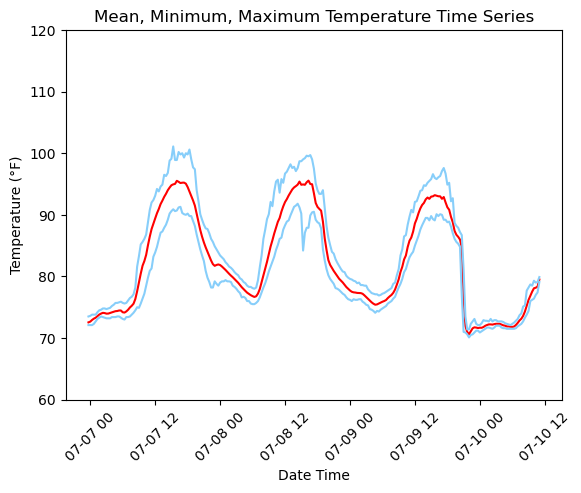

In [687]:
# Plot of mean, minimum, and maximum temperature time series

plt.plot(data_to_plot_mean.Date_Time_Format, data_to_plot_mean.Temperature, color='red')
plt.plot(data_to_plot_max.Date_Time_Format, data_to_plot_max.Temperature, color='lightskyblue')
plt.plot(data_to_plot_min.Date_Time_Format, data_to_plot_min.Temperature, color='lightskyblue')

plt.xticks(rotation=45)
plt.title('Mean, Minimum, Maximum Temperature Time Series')
plt.xlabel('Date Time')
plt.ylabel ('Temperature (\u00B0F)')
plt.yticks(np.arange(60, 121, 10))

#plt.savefig(os.path.join(folder_for_clean_csvs,'temp_mean_min_max_timeseries.png'))

([<matplotlib.axis.YTick at 0x301efd2e0>,
 [Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100'),
  Text(0, 110, '110'),
  Text(0, 120, '120')])

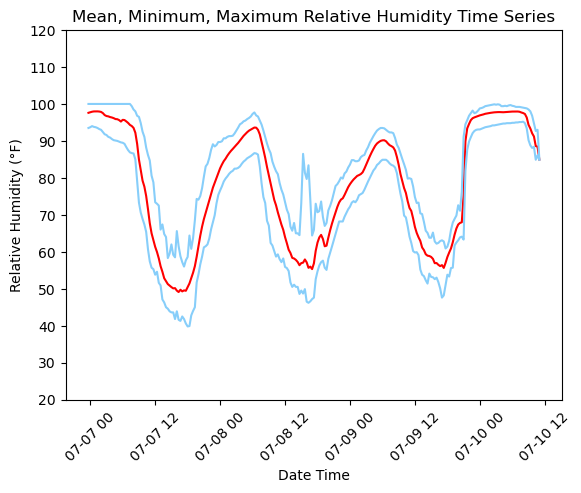

In [688]:
# Plot of mean, minimum, and maximum relative humidity time series

plt.plot(data_to_plot_mean.Date_Time_Format, data_to_plot_mean.Relative_Humidity, color='red')
plt.plot(data_to_plot_max.Date_Time_Format, data_to_plot_max.Relative_Humidity, color='lightskyblue')
plt.plot(data_to_plot_min.Date_Time_Format, data_to_plot_min.Relative_Humidity, color='lightskyblue')

plt.xticks(rotation=45)
plt.title('Mean, Minimum, Maximum Relative Humidity Time Series')
plt.xlabel('Date Time')
plt.ylabel ('Relative Humidity (\u00B0F)')
plt.yticks(np.arange(20, 121 , 10))

#plt.savefig(os.path.join(folder_for_clean_csvs,'humidity_mean_min_max_timeseries.png'))

([<matplotlib.axis.YTick at 0x301fcae10>,
 [Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100'),
  Text(0, 110, '110'),
  Text(0, 120, '120')])

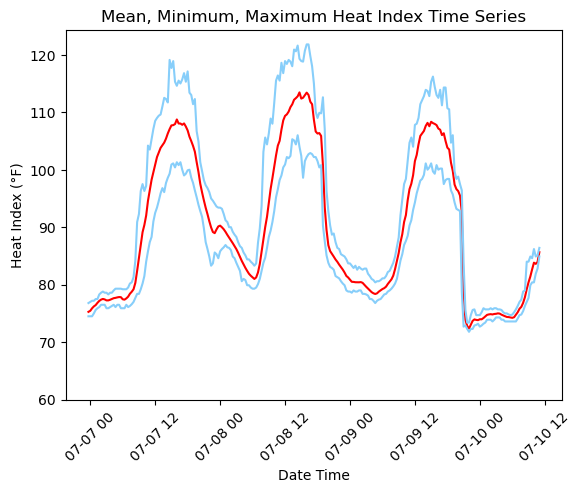

In [689]:
# Plot of mean, minimum, and maximum heat index time series

plt.plot(data_to_plot_mean.Date_Time_Format, data_to_plot_mean.Heat_Index, color='red')
plt.plot(data_to_plot_max.Date_Time_Format, data_to_plot_max.Heat_Index, color='lightskyblue')
plt.plot(data_to_plot_min.Date_Time_Format, data_to_plot_min.Heat_Index, color='lightskyblue')

plt.xticks(rotation=45)
plt.title('Mean, Minimum, Maximum Heat Index Time Series')
plt.xlabel('Date Time')
plt.ylabel ('Heat Index (\u00B0F)')
plt.yticks(np.arange(60, 121, 10))

#plt.savefig(os.path.join(folder_for_clean_csvs,'hi_mean_min_max_timeseries.png'))